In [1]:
import os
import sys  
import rasterio

import pandas as pd

from rasterio.plot import show

import numpy as np

#from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

from geneticalgorithm import geneticalgorithm as ga

root = os.getcwd() + "/.."

sys.path.insert(0, root)
import src.camera_allocation_functions as aptitude

In [2]:

fp1 = '../data/processed/aguascalientes/00_clossenes_to_streets_normalized_ags'
walls = rasterio.open(fp1)

fp2 = '../data/processed/aguascalientes/01_densidad_delitos_sobre_calle_1998'
crime_density = rasterio.open(fp2)

fp3 = '../data/processed/aguascalientes/02_manzanas_raster_binary'
blocks = rasterio.open(fp3)

fp4 = '../data/processed/aguascalientes/delitos_ags_2018_raster_bin'
crime = rasterio.open(fp4)
C = crime.read(1)
#crime = crime_density.read(1)

#correction
S = blocks.read(1)
S[S==255] = 0

CD = crime_density.read(1)

W = walls.read(1)

In [3]:
C

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Text(0.5, 0.98, 'Required Maps')

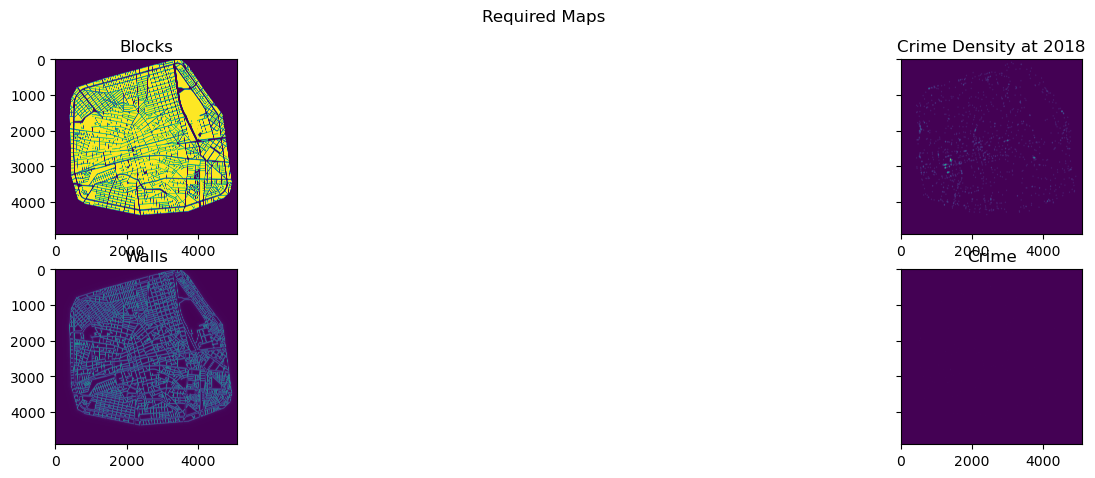

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(20, 5), sharey=True)
axs[0][0].imshow(S)
axs[0][0].set_title("Blocks")
axs[1][0].imshow(W)
axs[1][0].set_title("Walls")
axs[0][1].imshow(CD)
axs[0][1].set_title("Crime Density at 2018")
axs[1][1].imshow(C)
axs[1][1].set_title("Crime")
fig.suptitle('Required Maps')

In [5]:
C[(0,0)]

0

In [6]:
DF = pd.read_csv("fitness_positions_vc_area.csv")



In [7]:
DF

,Unnamed: 0,visibility coefficient,area,i,j
0,0,0.000000e+00,0.0,0,0
1,1,2.034909e-12,10201.0,50,2896
2,2,4.599369e-12,10201.0,50,2897
3,3,1.009319e-11,10201.0,50,2898
4,4,1.906279e-11,10201.0,50,2899
...,...,...,...,...,...
3685290,3685290,1.236886e-11,10201.0,4459,2456
3685291,3685291,9.348137e-12,10201.0,4459,2457
3685292,3685292,6.607297e-12,10201.0,4459,2458
3685293,3685293,4.140768e-12,10201.0,4459,2459


In [8]:
#rank = "area"
rank = "visibility coefficient"
DF_sort = DF.sort_values(by = [rank], ascending = False)

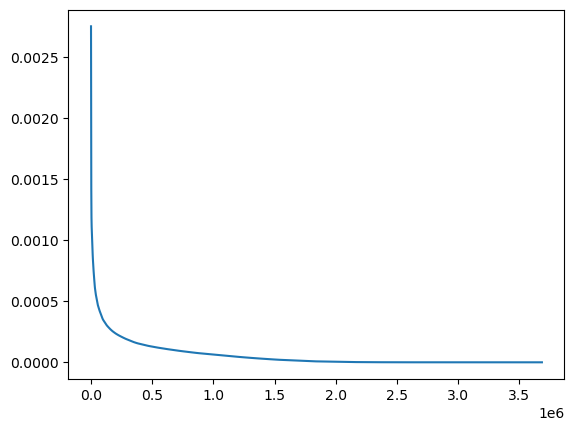

In [9]:
plt.plot(np.array(DF_sort[:][rank]))

#descartando las posiciones cercanas a la mejor

Algoritmo:
    
1. Ordenar las posiciones de acuerdo a su indice de visibilidad


In [18]:
# se debería llamar R de Radio
radius = 50

#Ordenar las posiciones de acuerdo a su indice de visibilidad (DF_init)

#seleccionar la mejor posición 
DF_init = DF_sort.iloc[[0]]

#detectar que posiciones están dentro del radio 
selected_rows = ((DF_sort.iloc[0]["i"] - DF_sort["i"])**2 + (DF_sort.iloc[0]["j"] - DF_sort["j"])**2)**(0.5)>=radius

#hacer una lista con las posiciones que estan fuera del radio
DF_sort = DF_sort[selected_rows]

#
c = 0
while len(DF_sort)>0 and np.sum(selected_rows)>0:
    
    selected_rows = ((DF_sort.iloc[0]["i"] - DF_sort["i"])**2 + (DF_sort.iloc[0]["j"] - DF_sort["j"])**2)**(0.5)>=radius
   
    if np.sum(selected_rows)>0:
    
        DF_sort = DF_sort[selected_rows]
        DF_init = pd.concat([DF_init, DF_sort.iloc[[0]]])
    
    if c%1000==0:  
        print(np.sum(selected_rows))
    
    c += 1
        

3677775
1800490
781124
144747


In [19]:
#nmax = 10
#ixs = np.arange(len(DF_sort))
#np.random.shuffle(ixs)



In [20]:
n_sensors = 100
Xresh = np.array(DF_init.iloc[:n_sensors][["i","j"]]).astype(int)


In [21]:


COVERS = np.zeros((n_sensors+1, S.shape[0], S.shape[1]))

for i, x in enumerate(Xresh):
    
    si = tuple(x)
   # print(si)
    
    Z = np.zeros((radius*2+1, radius*2+1))
    Z[(radius*2, radius*2)] = 1
    
    S_sub = np.copy(S[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
    CD_sub = np.copy(CD[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
    C_sub = np.copy(C[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
    isovist = aptitude.isovista(S_sub)
    K = aptitude.gkern(radius*2 + 1, 4)
    Kth = 0.000001
    
    # esta es la línea que calcula el número de delitos (C_sub) dentro del radio de visión  de la camara (K>th) y su isovista (isovist)
    COVERS[i+1, si[0]-radius : si[0] + radius + 1, si[1]-radius:si[1]+radius+1] = C_sub*(K>Kth)*isovist
    
max_covers = np.max(COVERS, axis=0)
arg_max_covers = np.argmax(COVERS, axis=0)

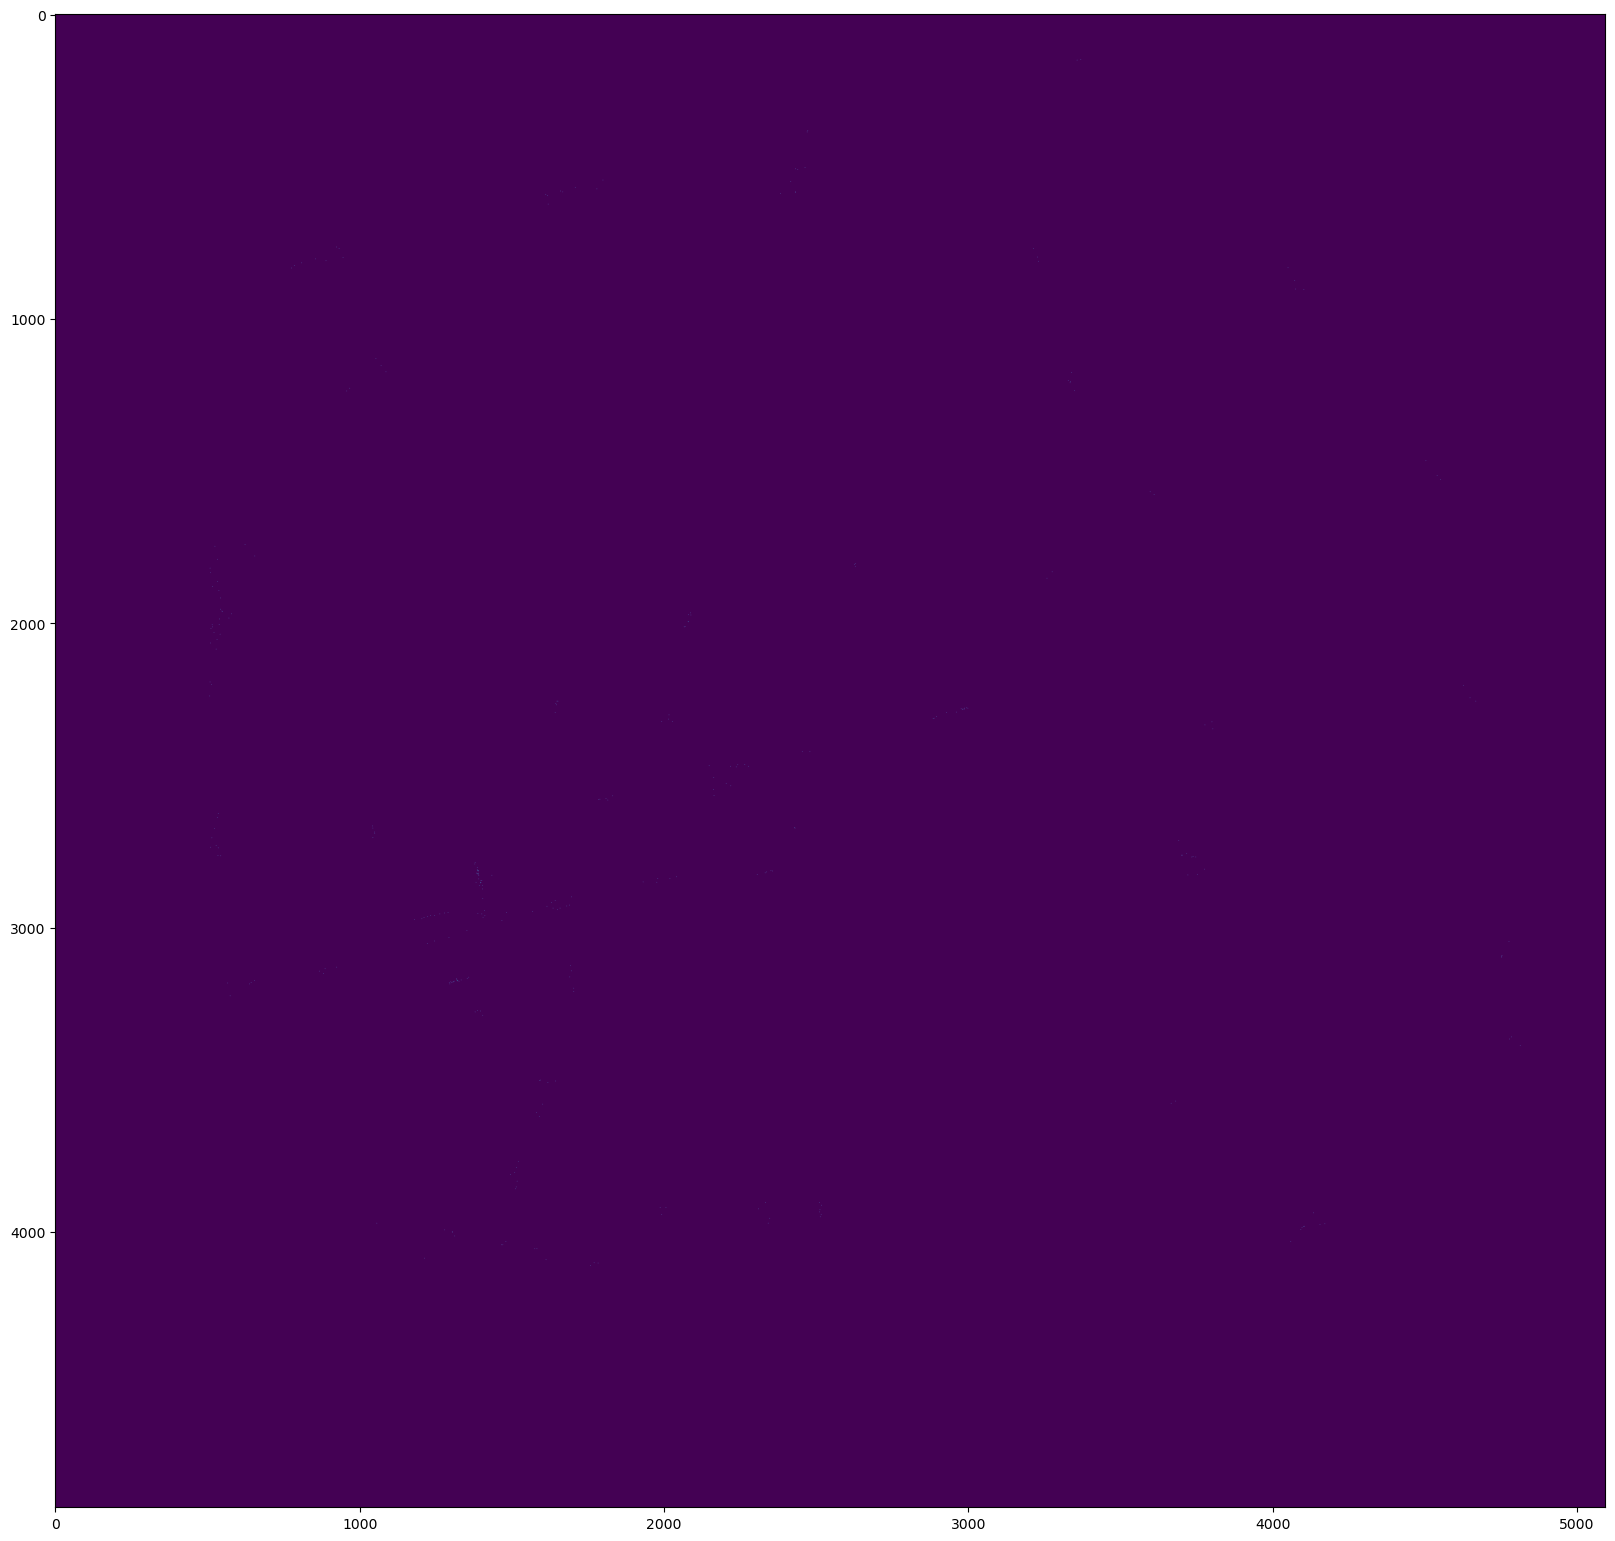

In [22]:
plt.figure(figsize=(20, 20))
plt.imshow(max_covers)
plt.show()

**Notas e Hipotesis**

* No necesariamente cubrir mas área es cubrir mas delitos
* Hay un compromiso de cubrir area vs densidad de delitos



**Contando los delitos dentro del radio de la isovista de la camara**

In [38]:
np.sum(max_covers)

319.0

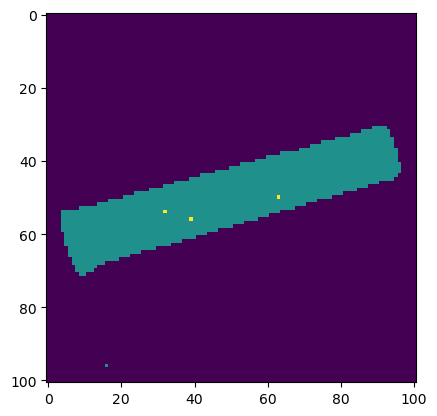

In [39]:
plt.imshow(C_sub+(isovist*(K>0.000001)))

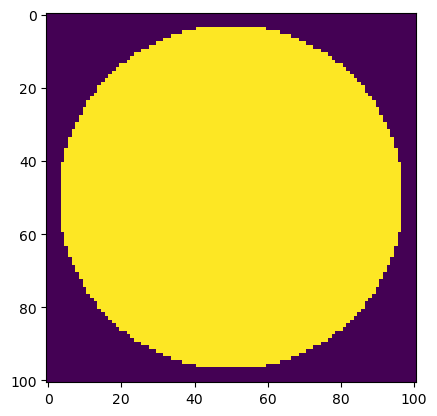

In [41]:
#radio de visión de una camara 360
plt.imshow(K>0.000001)

Text(0.5, 1.0, 'número de delitos : 3')

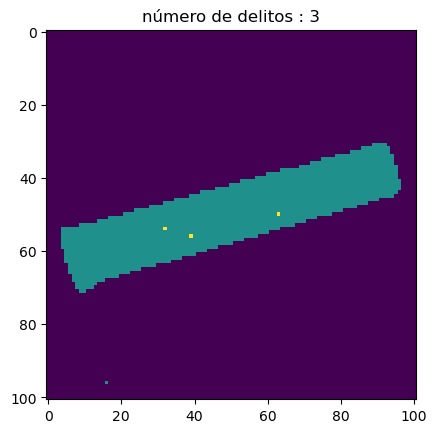

In [47]:
# delitos detectados dentro del radio de visión y la isovista
plt.imshow(C_sub+(isovist*(K>0.000001)))
plt.title("número de delitos : {n}".format( n= np.sum((C_sub*isovist*K>0.000001))))